<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

Importing pion sample data for training and testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/pion_predictions/'

pion_predictions_train = np.load(dir + 'pion_predictions_train.npy')
pion_predictions_test = np.load(dir + 'pion_predictions_test.npy')

print('Training data shape:', pion_predictions_train.shape)
print('Test data shape:', pion_predictions_test.shape)

Training data shape: (947947, 128)
Test data shape: (524521, 128)


# Toy example

1. Generate a $\mathcal{N}(0,1)$ distribution.
2. Estimate its density through KDE.
3. Compute the likelihood of several points as their evaluation in the KDE.

**Expected result:** The likelihoods decrease as the evaluation points grow further apart from 0.

Likelihood of 0 in KDE: 99.84%
Likelihood of 1 in KDE: 66.66%
Likelihood of 2 in KDE: 14.27%
Likelihood of 3 in KDE: 1.49%


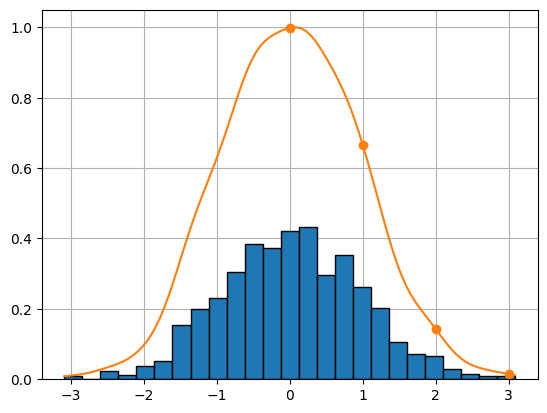

In [ ]:
def likelihood(kde, kde_max, value):
  return kde(value) / kde_max

data = np.random.normal(0, 1, 1000)
kde = gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
kde_x = kde(x)
kde_max = kde_x.max()

points = 0, 1, 2, 3
likelihoods = likelihood(kde, kde_max, points)

for point, like in zip(points, likelihoods):
  print(f'Likelihood of {point} in KDE: {round(100 * like, 2)}%')

plt.gca().set_axisbelow(True)
plt.grid()
plt.hist(data, 25, density=True, edgecolor='black')
plt.plot(x, likelihood(kde, kde_max, x))
plt.scatter(points, likelihoods, color='tab:orange')
plt.show()

# Results

In [ ]:
def plot_hist_kde(ax, d, data, kde):
  x = np.linspace(data.min(), data.max(), 100)
  ax.set_title(f'Dimension {d + 1}')
  ax.hist(data, 25, density=True)
  ax.plot(x, kde(x))

def estimate_likelihoods(train_data, test_data, eps=.01, n_samples=None, n_features=None, plot_shape=None):
  if not n_samples:
    n_samples = test_data.shape[0] # 524521 observations

  if not n_features:
    n_features = train_data.shape[1] # 128 dimensions

  if plot_shape:
    n_subplots = plot_shape[0] * plot_shape[1]

    if n_features != n_subplots:
      raise ValueError(f'Cannot plot {n_features} features in {n_subplots} subplots.')

    rows, columns = plot_shape
    fig, axes = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))

  likelihoods = np.zeros((n_samples, n_features))

  for j in range(n_features):
    train_sample = train_data[:10000, j]
    kde = gaussian_kde(train_sample)

    for i in range(n_samples):
      point = test_data[i, j]
      likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

    if plot_shape:
      plot_hist_kde(axes.flat[j], j, train_sample, kde)

  if plot_shape:
    plt.tight_layout()
    plt.show()

  return likelihoods

likelihoods = estimate_likelihoods(pion_predictions_train, pion_predictions_test, n_samples=128)

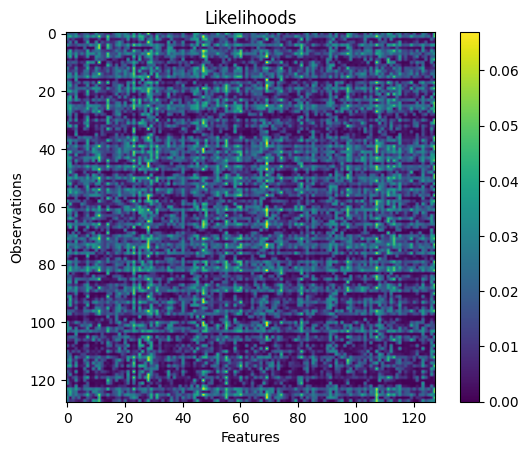

In [ ]:
def plot_likelihoods(likelihoods):
  plt.title('Likelihoods')
  plt.imshow(likelihoods)
  plt.xlabel('Features')
  plt.ylabel('Observations')
  plt.colorbar()
  plt.show()

plot_likelihoods(likelihoods)

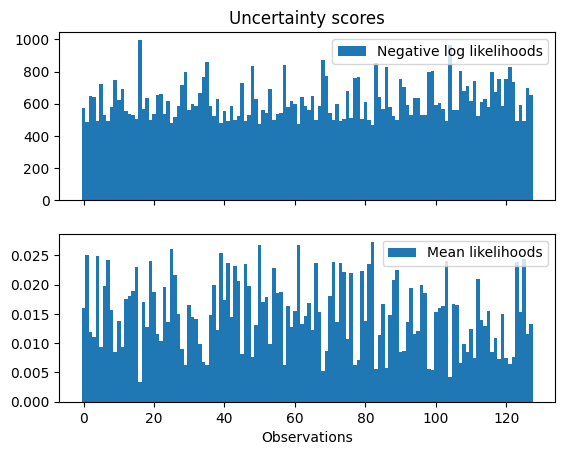

In [ ]:
def mean_likelihood(likelihoods):
  return likelihoods.mean(1)

def log_likelihood(likelihoods):
  likelihoods = likelihoods.copy()
  likelihoods[likelihoods == 0] = .01
  return np.log(likelihoods).sum(1)

def plot_likelihoods(ax, x, likelihoods, label):
  ax.bar(x, likelihoods, 1, label=label)
  ax.legend()

def plot_ue(likelihoods):
  log_likelihoods = log_likelihood(likelihoods)
  mean_likelihoods = mean_likelihood(likelihoods)

  fig, axes = plt.subplots(2, 1, sharex=True)
  x = range(likelihoods.shape[0])

  axes[0].set_title('Uncertainty scores')
  plot_likelihoods(axes[0], x, -log_likelihoods, 'Negative log likelihoods')
  plot_likelihoods(axes[1], x, mean_likelihoods, 'Mean likelihoods')
  axes[1].set_xlabel('Observations')
  plt.show()

plot_ue(likelihoods)

# Kaon testing

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/outputs/'

kaon_train_embeddings = np.load(dir + 'kaon_train_embeddings.npy')
kaon_test_targets = np.load(dir + 'kaon_test_targets.npy')
kaon_test_embeddings = np.load(dir + 'kaon_test_embeddings.npy')
kaon_test_predictions = np.load(dir + 'kaon_test_predictions.npy')

print('kaon train embeddings shape:', kaon_train_embeddings.shape)
print('kaon test targets shape:', kaon_test_targets.shape)
print('kaon test embeddings shape:', kaon_test_embeddings.shape)
print('Final predictions shape:', kaon_test_predictions.shape)

kaon train embeddings shape: (935276, 128)
kaon test targets shape: (532300, 5)
kaon test embeddings shape: (532300, 128)
Final predictions shape: (532300, 5)


Generating likelihoods for first 10k samples.

In [ ]:
n_samples, n_features = 10000, kaon_test_embeddings.shape[1]
likelihoods = np.zeros((n_samples, n_features))
eps = .01

for j in range(n_features):
  train_sample = kaon_train_embeddings[:10000, j]
  kde = gaussian_kde(train_sample)

  for i in range(n_samples):
    point = kaon_test_embeddings[i, j]
    likelihoods[i, j] = kde.integrate_box_1d(point - eps, point + eps)

np.save(dir + 'kaon_likelihoods.npy', likelihoods)

Load likelihoods from file if the runtime environment has been disconnected.

In [ ]:
likelihoods = np.load(dir + 'kaon_likelihoods.npy')

Plot correlation for first 10k samples.

Found null likelihoods! Replacing them with 0.01...


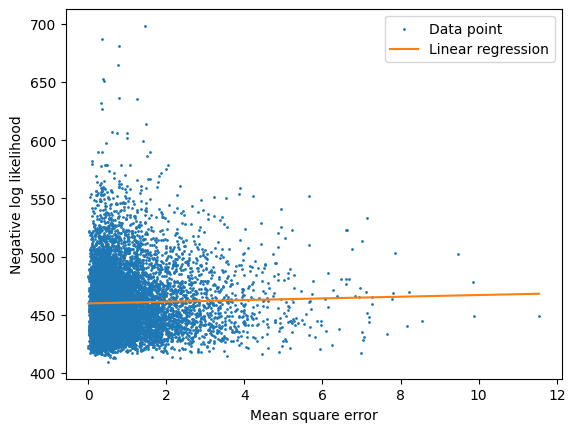

Correlation coefficient: 0.025566428470055524


In [ ]:
from scipy.stats import linregress

kaon_test_targets = kaon_test_targets[:10000]
kaon_test_predictions = kaon_test_predictions[:10000]

mse = ((kaon_test_targets - kaon_test_predictions)**2).mean(1)

null_likelihood_indices = likelihoods == 0

if likelihoods[null_likelihood_indices].size:
  print('Found null likelihoods! Replacing them with 0.01...')
  likelihoods[null_likelihood_indices] = .01

log_likelihoods = -np.log(likelihoods).sum(1)

x = np.linspace(mse.min(), mse.max(), 2)
regress = linregress(mse, log_likelihoods)

plt.scatter(mse, log_likelihoods, 1, label='Data point')
plt.plot(x, regress.slope * x + regress.intercept, color='tab:orange', label='Linear regression')
plt.xlabel('Mean square error')
plt.ylabel('Negative log likelihood')
plt.legend()
plt.show()

print('Correlation coefficient:', regress.rvalue)